# Packages and Initialization

In [4]:
library(tidyverse)
library(httr2) # for making api requests
library(uuid)  # For generating a UUID
library(jsonlite) # for working with JSONs
library(ggExtra)

Warning message:
"package 'ggExtra' was built under R version 4.4.3"


In [6]:
get_league_leaderboard<- function(country,session_id){
    url <- "https://ch.tetr.io/api/users/by/league?"
    paginate <- TRUE
    paginate_key <- NULL
    all_players <- NULL
    
    while (paginate){
        if (is.null(paginate_key)){
            request <- request(url) %>%
        req_url_query(country = country,
                      limit = 100) %>%
        req_headers(
            `User-Agent` = "RemiliaScarlet",
            `X-Session-ID` = session_id
        )
        result <- req_perform(request)|> 
        resp_body_string()|>
        fromJSON()|>
        as.data.frame()|>
        flatten(recursive = TRUE)
        } else {
            request <- request(url) %>%
        req_url_query(country= country,
                      limit = 100,
                      after = paginate_key) %>%
        req_headers(
            `User-Agent` = "RemiliaScarlet",
            `X-Session-ID` = session_id,
        )
        result <- req_perform(request)|> 
        resp_body_string()|>
        fromJSON()|>
        as.data.frame()|>
        flatten(recursive = TRUE)
        }
        if (is.null(all_players)){
            all_players <- result
        } else {
            all_players <- full_join(all_players, result)
        }
        
        length <- nrow(result)
        if (length < 100){
        paginate <- FALSE
        } else {
        last_user <- slice_min(result,`data.entries.p.pri`)
        paginate_key <- last_user$`data.entries.p.pri`|>
        paste("0","0", sep = ":")
        }
        Sys.sleep(1)
    }
    return(all_players)
}
# Gets the last games played by the user
get_user_games_json <- function(username,session_id){
        url <- paste0("https://ch.tetr.io/api/users/",username,"/records/league/recent")
        request <- request(url) %>%
        req_headers(
            `User-Agent` = "RemiliaScarlet",
            `X-Session-ID` = session_id
        )
        result <- req_perform(request)|> 
        resp_body_string()|>
        fromJSON(flatten = TRUE)
        Sys.sleep(1)
        return(result)
        
}

# Parse the match data json into a dataframe
parse_user_matches <- function(json){
    dataframe <- json$data$entries$results.rounds %>%
    bind_rows(.id = "column_label") %>%
    select(-c(id,
              username,
              shadows,
              shadowedBy,
              stats.altitude,
              stats.targetingfactor,
              stats.targetinggrace,
              stats.escapeartist,
              stats.blockrationing_app,
              stats.blockrationing_final,
              stats.rank,stats.revives)
          )%>%
    pivot_wider(names_from = naturalorder, values_from = active:stats.btb) %>%
    select(-c(active_0,active_1,naturalorder_0,naturalorder_1))
    return(dataframe)
}


In [129]:
UUID <- UUIDgenerate()

In [131]:
league_leaderboard <- get_league_leaderboard("CA",UUID)

Joining with `by = join_by(success, data.entries._id, data.entries.username, data.entries.role, data.entries.xp,
data.entries.supporter, data.entries.country, data.entries.ts, data.entries.gamesplayed, data.entries.gameswon,
data.entries.gametime, data.entries.ar, cache.status, cache.cached_at, cache.cached_until,
data.entries.league.gamesplayed, data.entries.league.gameswon, data.entries.league.glicko, data.entries.league.rd,
data.entries.league.tr, data.entries.league.gxe, data.entries.league.rank, data.entries.league.bestrank,
data.entries.league.apm, data.entries.league.pps, data.entries.league.vs, data.entries.league.decaying,
data.entries.ar_counts.1, data.entries.ar_counts.2, data.entries.ar_counts.3, data.entries.ar_counts.4,
data.entries.ar_counts.5, data.entries.ar_counts.100, data.entries.ar_counts.t100, data.entries.p.pri,
data.entries.p.sec, data.entries.p.ter)`
Joining with `by = join_by(success, data.entries._id, data.entries.username, data.entries.role, data.entries.xp,

In [158]:
user_list <- league_leaderboard$data.entries.username

[1] 1709

In [159]:
matches <- map(user_list, function(element) parse_user_matches(get_user_games_json(element,UUID))) %>%
                bind_rows()

In [ ]:
UUID <- UUIDgenerate()

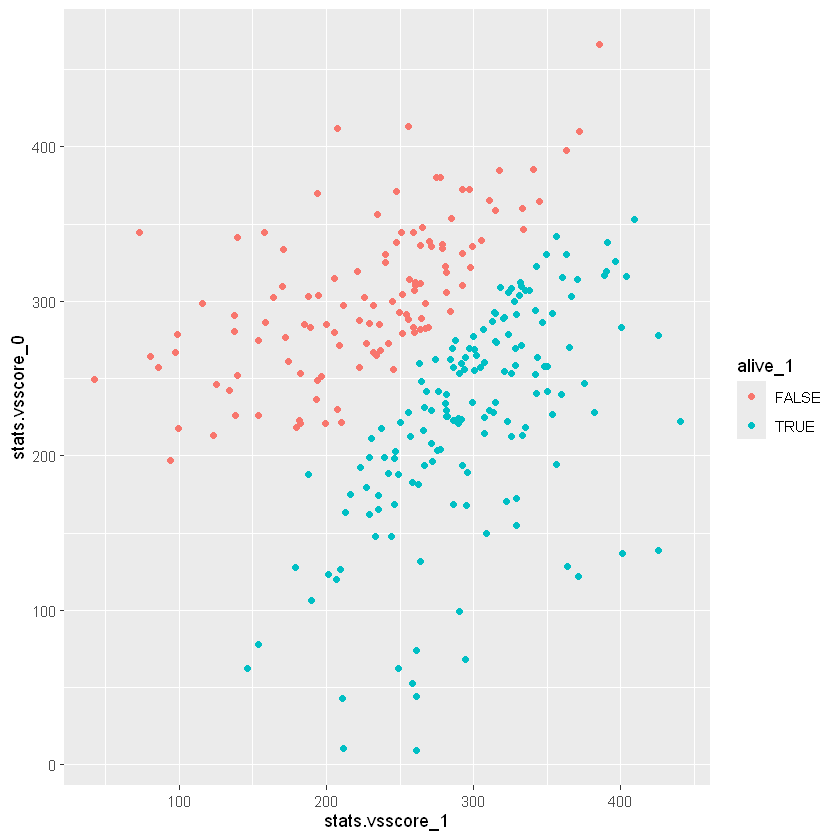

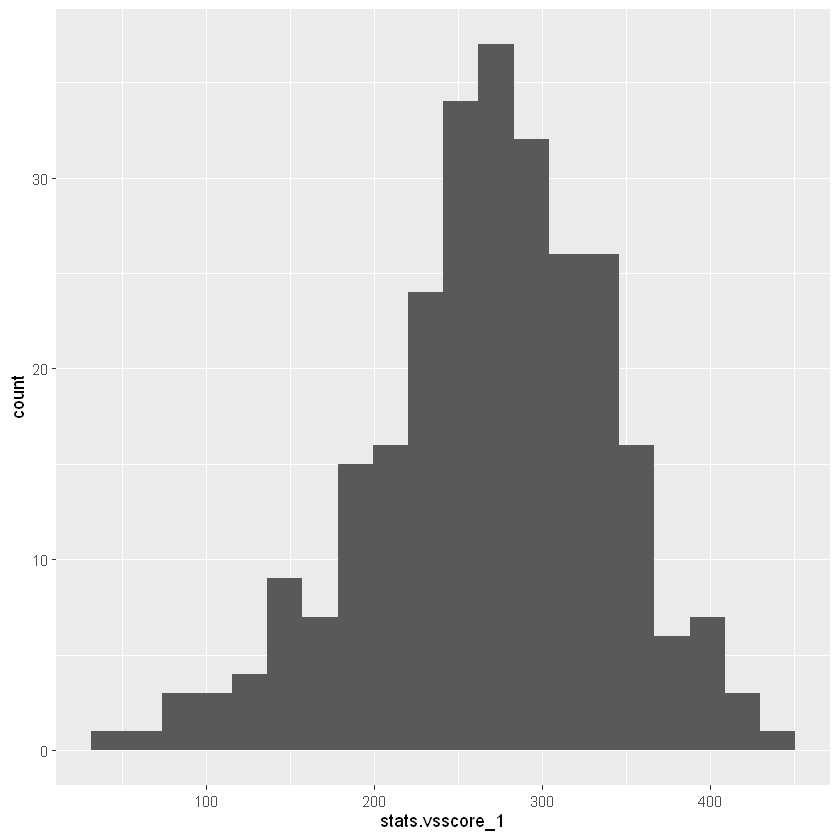

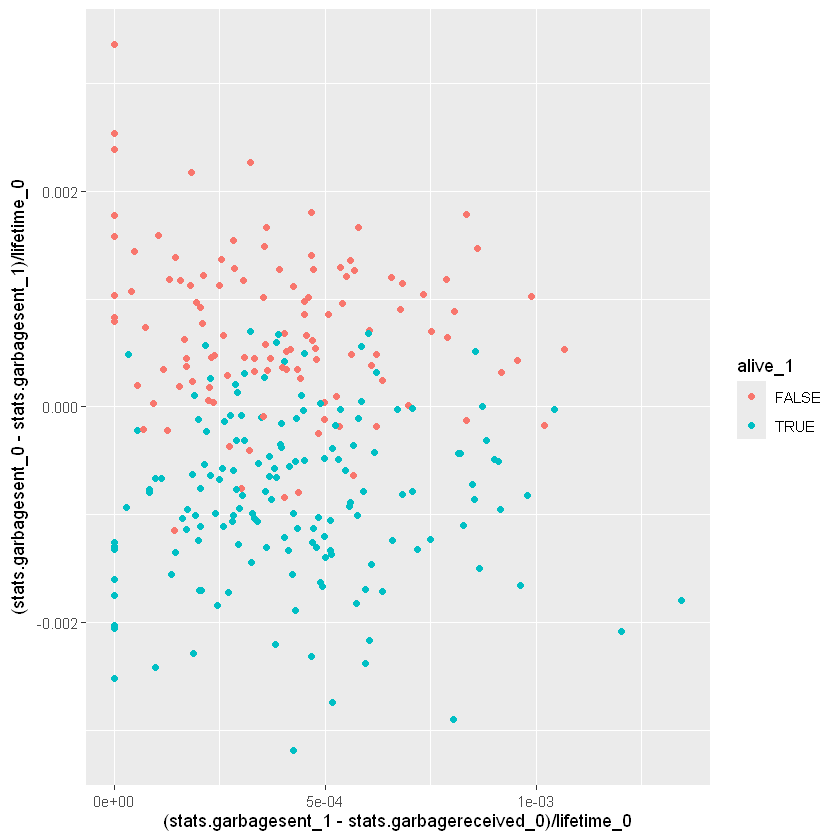

In [16]:
hp_data <- get_user_games_json("ploo", UUID) %>%
    parse_user_matches()


ggplot(hp_data, aes( x = stats.vsscore_1, stats.vsscore_0, color = alive_1)) + geom_point()
ggplot(hp_data, aes(stats.vsscore_1)) + geom_histogram(bins = 20)
ggplot(hp_data, aes(x = (stats.garbagesent_1 - stats.garbagereceived_0)/	lifetime_0 , y = (stats.garbagesent_0 - stats.garbagesent_1)/lifetime_0 , color = alive_1)) + geom_point()

Warning message:
"Removed 28897 rows containing non-finite outside the scale range (`stat_density2d()`)."


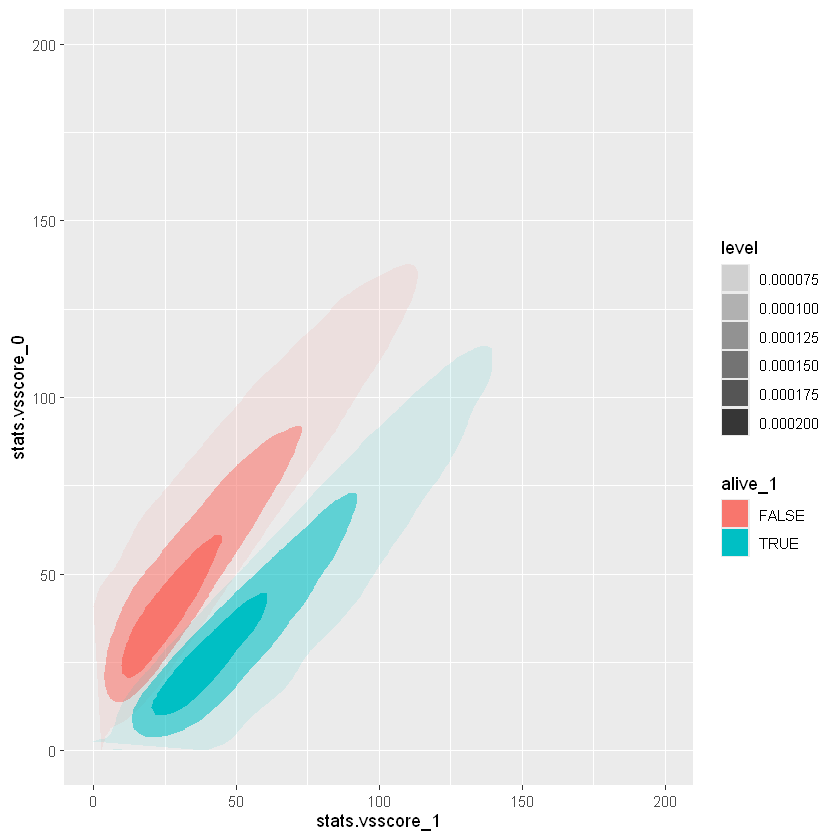

In [175]:
ggplot(matches, aes( x = stats.vsscore_1, stats.vsscore_0, group = alive_1)) +
    # geom_point(alpha = 0.01)+
    stat_density_2d(geom = "polygon",
                  aes(alpha = ..level.., fill = alive_1),
                  bins = 4)+ 
    ylim(0,200)+
    xlim(0,200)

In [164]:
write_csv(matches, "matches.csv")

In [170]:
colnames(matches)

[1] "column_label"            "alive_1"                
 [3] "alive_0"                 "lifetime_1"             
 [5] "lifetime_0"              "stats.apm_1"            
 [7] "stats.apm_0"             "stats.pps_1"            
 [9] "stats.pps_0"             "stats.vsscore_1"        
[11] "stats.vsscore_0"         "stats.garbagesent_1"    
[13] "stats.garbagesent_0"     "stats.garbagereceived_1"
[15] "stats.garbagereceived_0" "stats.kills_1"          
[17] "stats.kills_0"           "stats.btb_1"            
[19] "stats.btb_0"

In [172]:
ggpairs(matches,stats.apm_1:stats.vsscore_0)

ERROR: Error in ggpairs(matches, stats.apm_1:stats.vsscore_0): could not find function "ggpairs"
